In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import requests
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import random
from ultralytics import YOLO
import torch
from collections import defaultdict
from collections import Counter
from datetime import datetime
from elasticsearch import Elasticsearch
from elasticsearch import helpers 
from datetime import timezone
from dotenv import load_dotenv
import os

load_dotenv()


True

In [2]:
# remove all files in test_gov_traffic_data
for file in os.listdir('test_gov_traffic_data'):
    os.remove(os.path.join('test_gov_traffic_data', file))

# Create output directory if it doesn't exist
output_dir = 'test_gov_traffic_data'
os.makedirs(output_dir, exist_ok=True)

# Read the CSV file
df = pd.read_csv('Traffic_Camera_Locations_Sc.csv')

for i in range(len(df)):
    try:
        url = df.iloc[i]['url']
        key = df.iloc[i]['key']
        
        # Download image with requests instead of cv2.imread
        headers = {'User-Agent': 'Mozilla/5.0'}  # Some sites require user-agent
        response = requests.get(url, headers=headers, timeout=10)
        
        if response.status_code == 200:
            # Convert bytes to numpy array
            img_array = np.asarray(bytearray(response.content), dtype=np.uint8)
            
            # Decode image using OpenCV
            img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
            
            if img is not None:
                # Create safe filename
                filename = f"{key}.jpg"
                output_path = os.path.join(output_dir, filename)
                
                # Save image
                if cv2.imwrite(output_path, img):
                    print(f"Saved: {filename}")
                else:
                    print(f"Failed to save: {filename}")
            else:
                print(f"Failed to decode image from: {url}")
        else:
            print(f"Failed to download: {url} (Status code: {response.status_code})")
            
    except Exception as e:
        print(f"Error processing {url}: {str(e)}")

Saved: H429F.jpg
Saved: H210F.jpg
Saved: H421F.jpg
Saved: H422F2.jpg
Saved: H904F.jpg
Saved: H216F.jpg
Saved: H305F.jpg
Saved: H106F.jpg
Saved: H110F.jpg
Saved: H138F.jpg
Saved: H207F.jpg
Saved: H204F.jpg
Saved: H222F.jpg
Saved: H215F.jpg
Saved: H214F.jpg
Saved: H201F.jpg
Saved: H802F.jpg
Saved: H801F.jpg
Saved: H803F.jpg
Saved: H307F.jpg
Saved: H903F.jpg
Saved: H107F.jpg
Saved: H130F.jpg
Saved: H132F2.jpg
Saved: H109F.jpg
Saved: H108F.jpg
Saved: H209F.jpg
Saved: H422F1.jpg
Saved: H401F.jpg
Saved: H203F.jpg
Saved: K202F.jpg
Saved: K209F.jpg
Saved: K104F.jpg
Saved: K106F.jpg
Saved: K109F.jpg
Saved: K221F.jpg
Saved: K305F.jpg
Saved: K802F.jpg
Saved: TK110F.jpg
Saved: K627F.jpg
Saved: K107F.jpg
Saved: K108F.jpg
Saved: K613F.jpg
Saved: K404F.jpg
Saved: K325F.jpg
Saved: K814F.jpg
Saved: K812F.jpg
Saved: K813F.jpg
Saved: K621F.jpg
Saved: K809F2.jpg
Saved: K810F.jpg
Saved: K602F.jpg
Saved: K804F.jpg
Saved: K505F.jpg
Saved: K614F.jpg
Saved: K508F.jpg
Saved: K405F.jpg
Saved: K205F.jpg
Saved: TK


image 1/1 c:\Users\orkev\Desktop\Project\yolov8_Vehicle_Detection\test_gov_traffic_data\AID01101.jpg: 320x416 1 truck, 14.0ms
Speed: 0.7ms preprocess, 14.0ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 416)


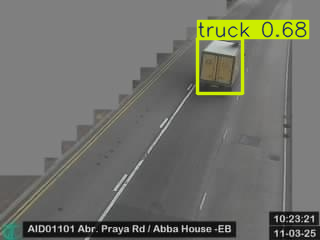

Object counts:
truck: 1


In [22]:
from collections import defaultdict

dir = "test_gov_traffic_data"
model = YOLO("yolo11x.pt")
device = "0" if torch.cuda.is_available() else "cpu"

#get first image in dir
results = model.predict(source = os.path.join(dir, os.listdir(dir)[0]),imgsz=(416), device=device)
plot = results[0].plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
display(Image.fromarray(plot))
# get names in result
names = result[0].names
counts = defaultdict(int)

for result in results:
    for box in result.boxes:
        class_id = int(box.cls)  # Get class ID
        class_name = model.names[class_id]  # Map to class name
        counts[class_name] += 1  # Increment count

# Print results
print("Object counts:")
for name, count in counts.items():
    print(f"{name}: {count}")


In [4]:

dir = "test_gov_traffic_data"
model = YOLO("yolo11x.pt")
device = "0" if torch.cuda.is_available() else "cpu"

hong_kong_road_data = []
df = pd.read_csv('Traffic_Camera_Locations_Sc.csv')

# need UTC 0
current_iso_date = datetime.now(timezone.utc).isoformat()


for image in os.listdir(dir):
    result = model.predict(source = os.path.join(dir, image),imgsz=(416), device=device)
    image_file_name = image.split(".")[0]
    region = df[df['key'] == image_file_name]['region'].values[0]
    district = df[df['key'] == image_file_name]['district'].values[0]
    description = df[df['key'] == image_file_name]['description'].values[0]
    #find location by image_file_name
    location = df[df['key'] == image_file_name]
    print(location.keys())
    latitude = location['latitude'].values[0].item()
    longitude = location['longitude'].values[0].item()

    plot = result[0].plot()
    plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
    #display(Image.fromarray(plot))
    #print(result)
    # count truck, car and bus

    image_return_data = dict()

    vehicles_count = 0

    boxes = result[0].boxes
    if boxes.cls is not None and len(boxes.cls) > 0:
        classes = boxes.cls.cpu().numpy().astype(int) 
        class_names = [model.names[cls] for cls in classes]
        counts = Counter(class_names)
        
        #print(f"Image: {image}")
        for name , count in sorted(counts.items()):
            name_replace = name.replace(" ", "_")
            image_return_data[name_replace] = count
        #print("-" * 30) 
    else:
        print(f"Image: {image} - No objects detected")

    vehicles_count = image_return_data.get("car", 0) + image_return_data.get("truck", 0) + image_return_data.get("bus", 0)
        
    hong_kong_road_data.append({"@timestamp": current_iso_date ,"Key": image_file_name, "region": region, "district": district, "detail_location": description, "vehicles_count": vehicles_count, "image_item": image_return_data, "geolocation": {"lat": latitude, "lon": longitude} })

print(hong_kong_road_data)



image 1/1 c:\Users\orkev\Desktop\Project\yolov8_Vehicle_Detection\test_gov_traffic_data\AID01101.jpg: 320x416 2 cars, 1 truck, 17.4ms
Speed: 0.7ms preprocess, 17.4ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 416)
Index(['key', 'region', 'district', 'description', 'easting', 'northing',
       'latitude', 'longitude', 'url'],
      dtype='object')

image 1/1 c:\Users\orkev\Desktop\Project\yolov8_Vehicle_Detection\test_gov_traffic_data\AID01102.jpg: 320x416 1 car, 2 trucks, 13.6ms
Speed: 0.6ms preprocess, 13.6ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 416)
Index(['key', 'region', 'district', 'description', 'easting', 'northing',
       'latitude', 'longitude', 'url'],
      dtype='object')

image 1/1 c:\Users\orkev\Desktop\Project\yolov8_Vehicle_Detection\test_gov_traffic_data\AID01103.jpg: 320x416 (no detections), 16.5ms
Speed: 0.6ms preprocess, 16.5ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 416)
Index(['key', 'region', 'distric

In [5]:
ES_URL = os.getenv("ES_URL")
ES_USER =  os.getenv("ES_USER")
ES_PW =  os.getenv("ES_PW")

es = Elasticsearch(
    ES_URL,
    basic_auth=(ES_USER, ES_PW),
    verify_certs=False
)

# check if ilm policy exists
try:
    es.ilm.get_lifecycle(name="traffic_data_ilm")
    print("ILM policy already exists.")
except:
    es.ilm.put_lifecycle(
        name="traffic_data_ilm",
        body={
            "policy": {
                "phases": {
                    "hot": {
                        "min_age": "0ms",
                        "actions": {
                            "set_priority": {
                                "priority": 100
                            }
                        }
                    },
                    "delete": {
                        "min_age": "365d",
                        "actions": {
                            "delete": {}
                        }
                    }
                }
            }
        }
    )

c:\Users\orkev\anaconda3\envs\Yolo\Lib\site-packages\elasticsearch\_sync\client\__init__.py:403: SecurityWarning: Connecting to 'https://192.168.60.19:9200' using TLS with verify_certs=False is insecure
  _transport = transport_class(
c:\Users\orkev\anaconda3\envs\Yolo\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host '192.168.60.19'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\orkev\anaconda3\envs\Yolo\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host '192.168.60.19'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [6]:

#put index alias



#check index
if "traffic_data" not in es.indices.get_alias(index="*"):
    es.indices.create(
        index="traffic_data",
        body={
            "settings": {
                "number_of_shards": 1,
                "number_of_replicas": 0,
                "index.lifecycle.name": "traffic_data_ilm",         
                "index.lifecycle.rollover_alias": "traffic_data_alias"
            }, 
            "mappings": {
                "dynamic_templates": [
                    {
                        "all_fields_in_object_as_integer": {
                        "path_match": "image_item.*",
                            "mapping": {
                                "type": "integer"
                            }
                        }
                    }
                ],
                "properties": {
                    "@timestamp": {
                        "type": "date"
                    },
                    "Key": {
                        "type": "keyword"
                    },
                    "image_item": {
                        "type": "object"
                    },
                    "geolocation": {
                        "type": "geo_point"
                    },
                    "region": {
                        "type": "keyword"
                    },
                    "district": {
                        "type": "keyword"
                    },
                    "detail_location": {
                        "type": "text" 
                    },
                    "vehicles_count": {
                        "type": "integer"
                    }
                }
            },
            "aliases": {
                "traffic_data_alias": {
                    "is_write_index": True  
                }
            }
        }
    )
    es.indices.put_alias(index="traffic_data", name="traffic_data_alias")


bulk_data = []
for document in hong_kong_road_data:
    bulk_data.append({
        "_op_type": "index",       # Operation type (index/create/update/delete)
        "_index": "traffic_data",  # Target index
        "_source": document        # Your document data
    })

helpers.bulk(es, bulk_data)

c:\Users\orkev\anaconda3\envs\Yolo\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host '192.168.60.19'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
C:\Users\orkev\AppData\Local\Temp\ipykernel_33108\1283559879.py:6: ElasticsearchWarning: this request accesses system indices: [.kibana_8.17.3_001, .kibana_task_manager_8.17.3_001, .kibana_security_session_1, .apm-custom-link, .security-profile-8, .kibana_ingest_8.17.3_001, .kibana_security_solution_8.17.3_001, .apm-agent-configuration, .security-7, .kibana_usage_counters_8.17.3_001, .kibana_alerting_cases_8.17.3_001, .inference, .async-search, .kibana_analytics_8.17.3_001], but in a future major version, direct access to system indices will be prevented by default
  if "traffic_data" not in es.indices.get_alias(index="*"):
c:\Users\orkev\anaconda3\envs\Yolo\Lib\site-pa

(985, [])

In [41]:
bulk_data = []
for document in hong_kong_road_data:
    bulk_data.append({
        "_op_type": "index",       # Operation type (index/create/update/delete)
        "_index": "traffic_data-000001",  # Target index
        "_source": document        # Your document data
    })

helpers.bulk(es, bulk_data)

c:\Users\orkev\anaconda3\envs\Yolo\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host '192.168.60.19'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\orkev\anaconda3\envs\Yolo\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host '192.168.60.19'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


(986, [])